<a href="https://colab.research.google.com/github/garkul/Transcriptomics.msu/blob/master/HW_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Домашнее задание 13</h1>
<h3> Гаркуль Лидия 4 курс ФББ</h3>



### Установка нужных пакетов и программ

In [ ]:
# Install packages
!pip install scikit-misc scanpy cellrank scvelo python-igraph palantir
!pip install rpy2==3.5.1

# Restart runtime
# (it is needed to update Matplotlib version)
import os
os.kill(os.getpid(), 9)

In [ ]:
%load_ext rpy2.ipython

!Rscript -e 'install.packages("mgcv")'
!Rscript -e 'install.packages("plyr")'
!Rscript -e 'install.packages("dplyr")'
!Rscript -e 'install.packages("ggplot2")'
!Rscript -e 'install.packages("tidymv")'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import scvelo as scv
import cellrank as cr
import palantir
%matplotlib inline

# Настроим параметры изображений и степень подробности сообщений 
sc.set_figure_params(figsize=(7, 5))
sns.set_theme(style='whitegrid')
cr.settings.verbosity = 2

# Hide some of the warnings
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)

###1.Palantir смог хорошо идентифицировать как терминальное состояние, из которого клетки уже не могут перейти в другие типы, только бета-клетки. Попробуйте исключить из adata кластеры, соответствующие дельта- и эпсилон-клеткам, и запустить Palantir еще раз, теперь уже с двумя терминальными состояниями: альфа и бета. Как изменилась оценка энтропии для клеток? Какие выводы можно из этого сделать?

In [3]:
#скачиваем датасет
adata = cr.datasets.pancreas()
adata

  0%|          | 0.00/33.5M [00:00<?, ?B/s]

AnnData object with n_obs × n_vars = 2531 × 27998
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'day_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

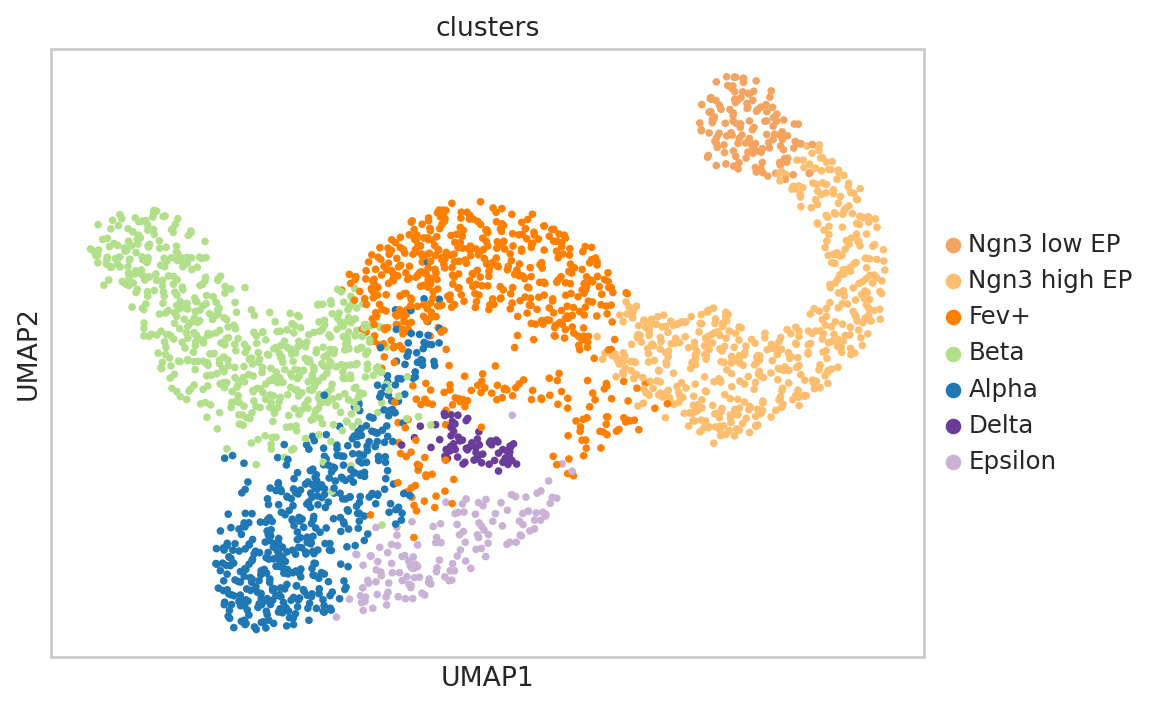

In [4]:
sc.pl.umap(adata, color="clusters")

In [5]:
#базовый препроцессинг
adata.layers["counts"] = adata.X.copy()
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=1500, subset=True, layer="counts", flavor="seurat_v3")

In [6]:
sc.pp.pca(adata)
adata_raw = adata.copy()

In [7]:
#удаляем эпсилон- и дельта-клетки из adata
adata = adata_raw.copy()
adata = adata[list((adata.obs['clusters'] != 'Delta') & (adata.obs['clusters'] != 'Epsilon')), :]
adata

View of AnnData object with n_obs × n_vars = 2322 × 1500
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'counts'
    obsp: 'connectivities', 'distances'

In [8]:
set(adata.obs['clusters'])

{'Alpha', 'Beta', 'Fev+', 'Ngn3 high EP', 'Ngn3 low EP'}

Determing nearest neighbor graph...


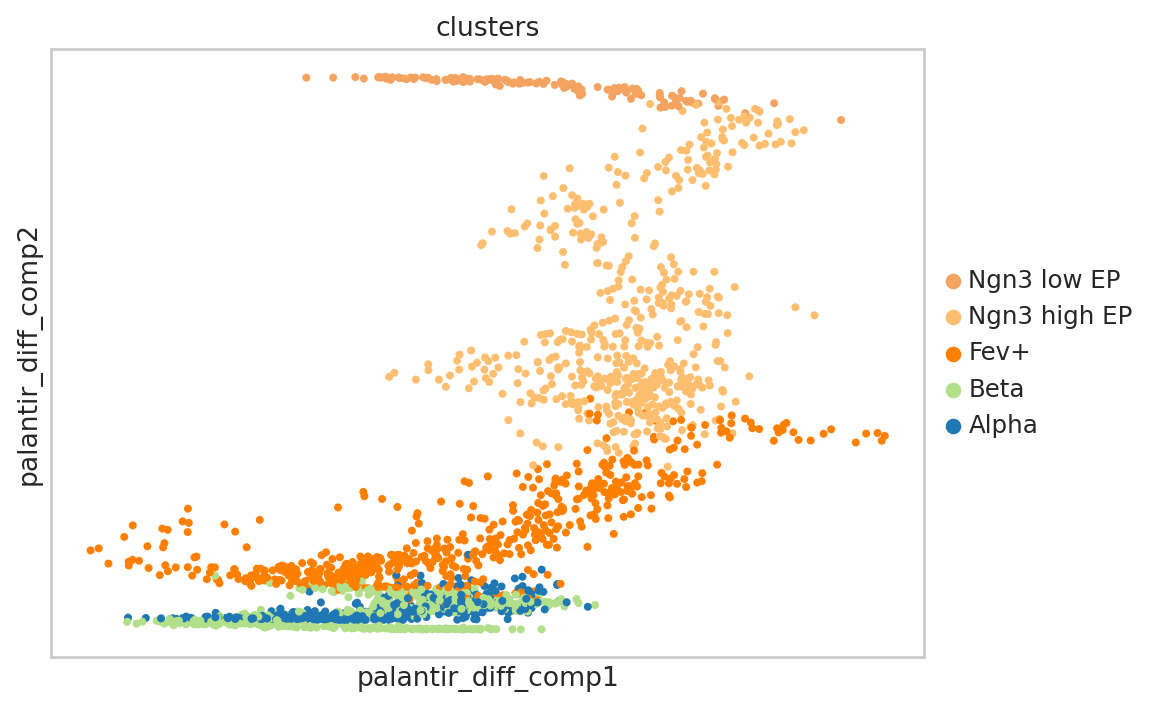

In [9]:
#запуск Palantir
sce.tl.palantir(adata, n_components=5, knn=30)
sc.pl.embedding(adata, basis="palantir_diff_comp", color="clusters")

In [10]:
#Отрисуем сами комопненты на нашем UMAP
adata.obs["DC1"] = adata.obsm["X_palantir_diff_comp"][:,0]
adata.obs["DC2"] = adata.obsm["X_palantir_diff_comp"][:,1]
adata.obs["DC3"] = adata.obsm["X_palantir_diff_comp"][:,2]

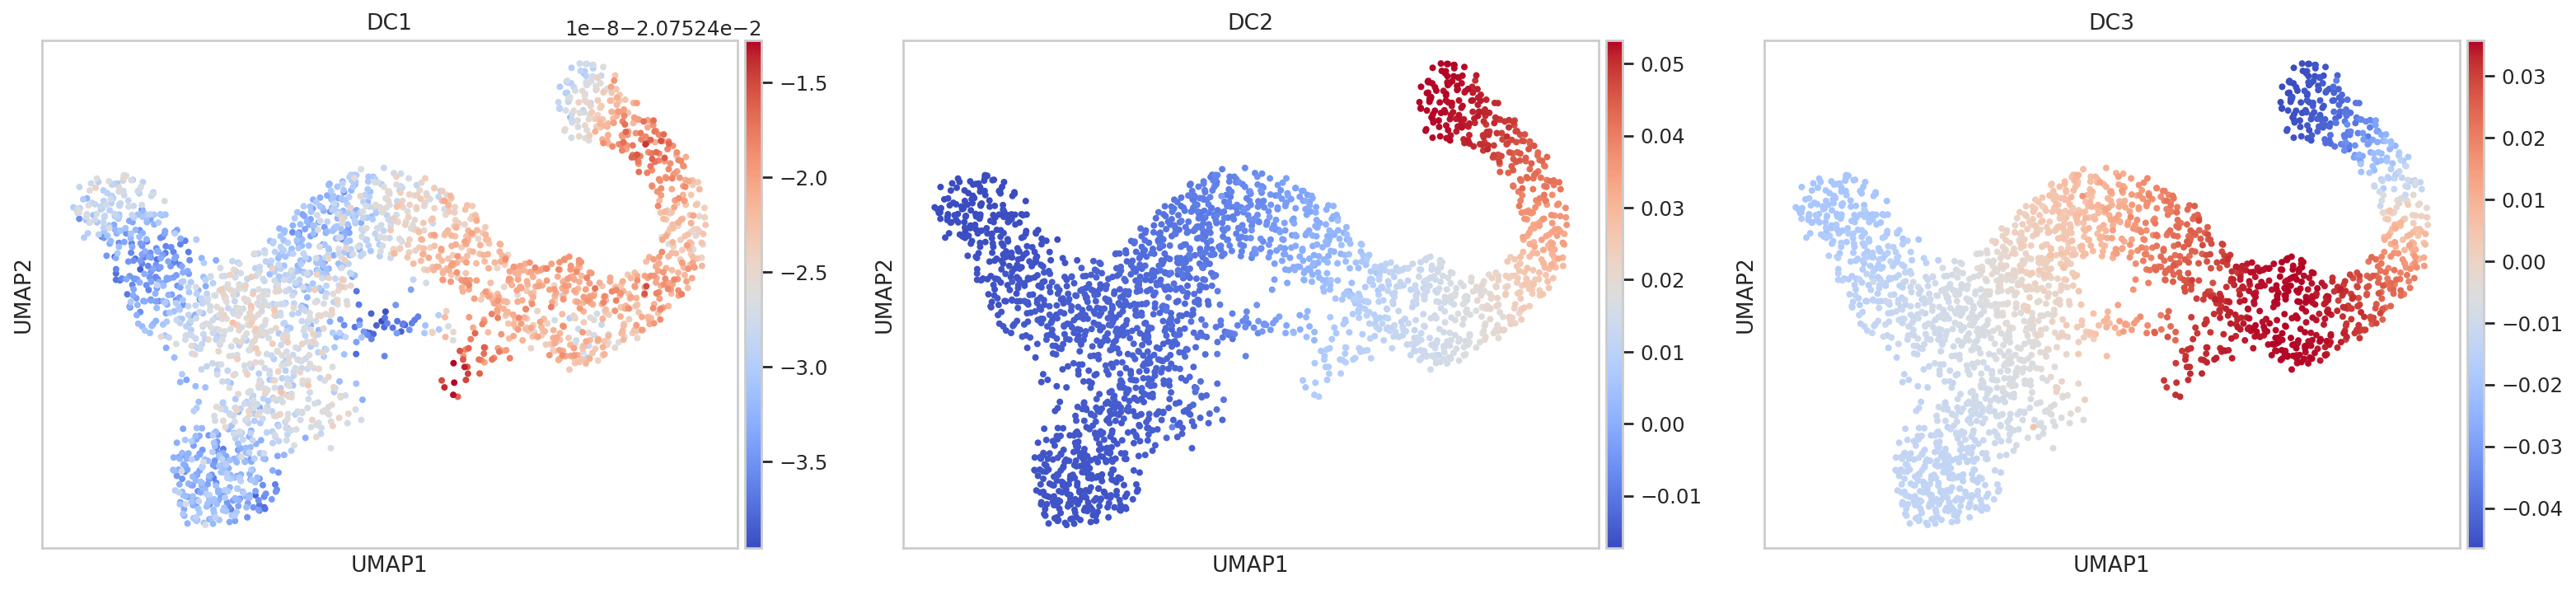

In [11]:
sc.pl.umap(adata, color=["DC1","DC2","DC3"], cmap="coolwarm")

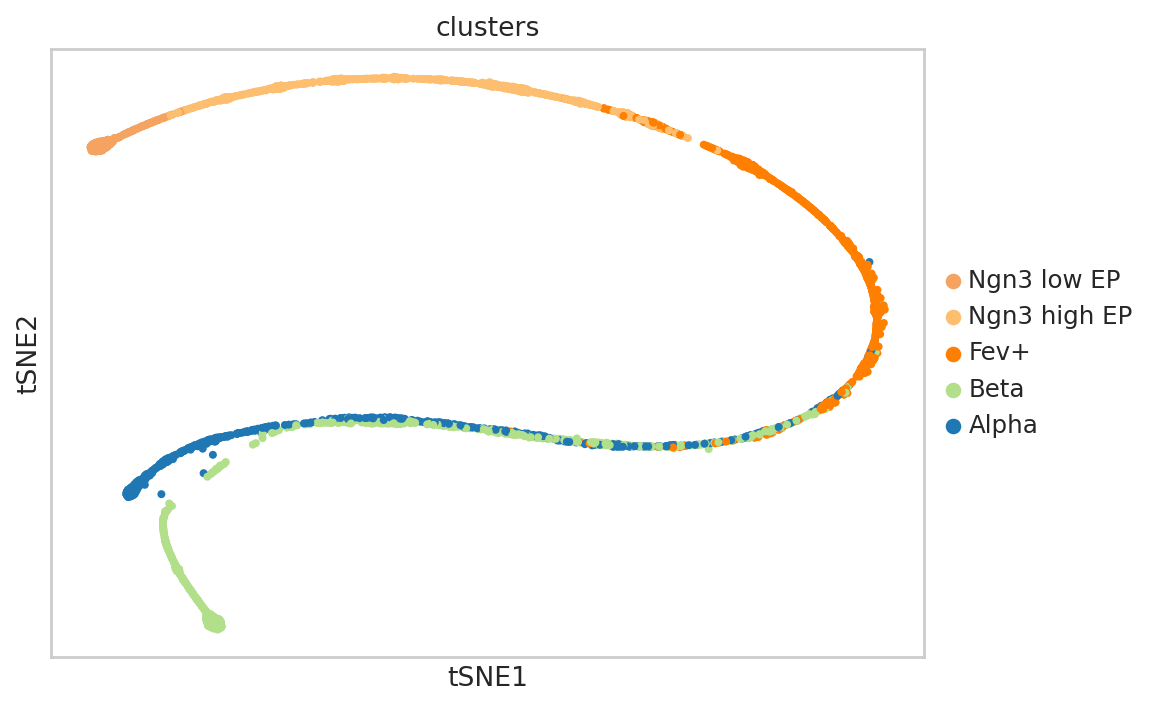

In [12]:
#Построим t-SNE по первым двум компонентам диффузии
sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)
sc.pl.tsne(adata, color="clusters")

In [13]:
cluster_dict = {"Root": adata.obs["clusters"] == "Ngn3 low EP",
                "Alpha": adata.obs["clusters"] == "Alpha",
                "Beta": adata.obs["clusters"] == "Beta"}

In [14]:
root_cell = adata.obs.index[cluster_dict["Root"]][0]
alpha_cell = adata.obs.index[cluster_dict["Alpha"]][15]
beta_cell = adata.obs.index[cluster_dict["Beta"]][10]

In [15]:
cluster_cells = {"Root": adata.obs.index==root_cell,
                "Alpha": adata.obs.index==alpha_cell,
                "Beta": adata.obs.index==beta_cell}

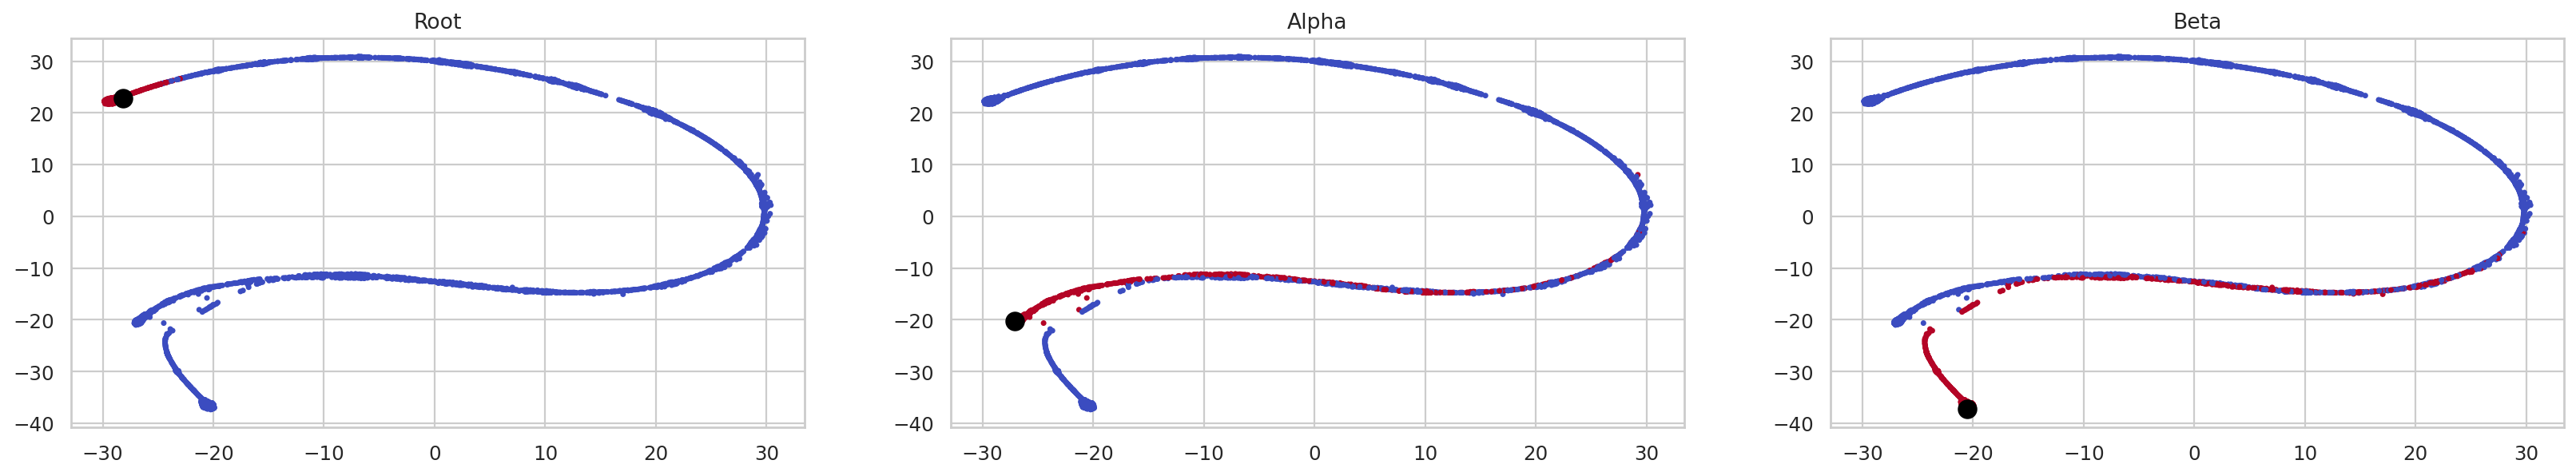

In [16]:
fig,axs = plt.subplots(1,3,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_tsne"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_tsne"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

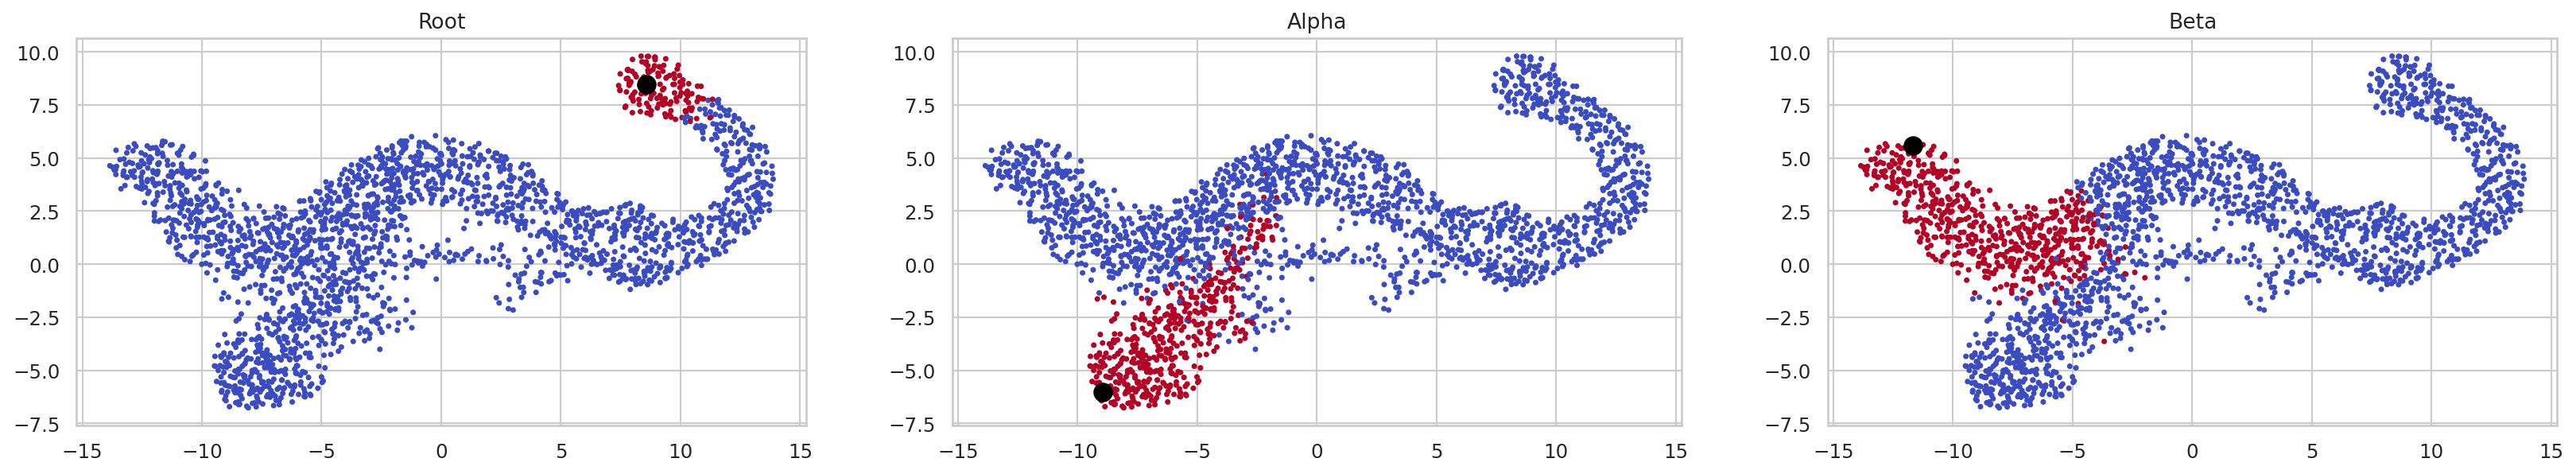

In [17]:
fig,axs = plt.subplots(1,3,figsize=(25,4))
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_umap"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_umap"][:,1][cluster_cells[cur_cluster]], c="black", s=100)
  ax.set_title(cur_cluster)

In [18]:
terminal_states = pd.Series(['Alpha', 'Beta'], 
                           index=[alpha_cell, beta_cell])

In [19]:
pr_res = sce.tl.palantir_results(
    adata,
    early_cell=root_cell,
    ms_data='X_palantir_multiscale',
    num_waypoints=500,
    terminal_states = terminal_states.index,
)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0035066485404968263 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.1528135895729065 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


In [20]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

In [21]:
pr_res.branch_probs

Beta     Alpha
index                                   
AAACCTGAGAGGGATA-1-3  0.276182  0.723818
AAACCTGAGGCAATTA-1-3  0.276206  0.723794
AAACCTGGTAAGTGGC-1-3  0.276182  0.723818
AAACCTGTCCCTCTTT-1-3  0.389192  0.610808
AAACGGGCAAAGAATC-1-3  0.276813  0.723187
...                        ...       ...
TTTGGTTCACGAAGCA-1-3  0.276182  0.723818
TTTGGTTTCCTTTCGG-1-3  0.282902  0.717098
TTTGTCAAGAATGTGT-1-3  0.276183  0.723817
TTTGTCAAGTGACATA-1-3  0.276182  0.723818
TTTGTCATCGAATGCT-1-3  0.451196  0.548804

[2322 rows x 2 columns]

In [22]:
adata.obs["pr_entropy"] = pr_res.entropy
adata.obs["pr_beta"] = pr_res.branch_probs["Beta"]
adata.obs["pr_alpha"] = pr_res.branch_probs["Alpha"]
adata

AnnData object with n_obs × n_vars = 2322 × 1500
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'DC1', 'DC2', 'DC3', 'pr_entropy', 'pr_beta', 'pr_alpha'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg', 'palantir_EigenValues', 'tsne'
    obsm: 'X_pca', 'X_umap', 'X_palantir_diff_comp', 'X_palantir_multiscale', 'X_tsne'
    varm: 'PCs'
    layers: 'spliced', 'unspliced', 'counts', 'palantir_imp'
    obsp: 'connectivities', 'distances', 'palantir_diff_op'

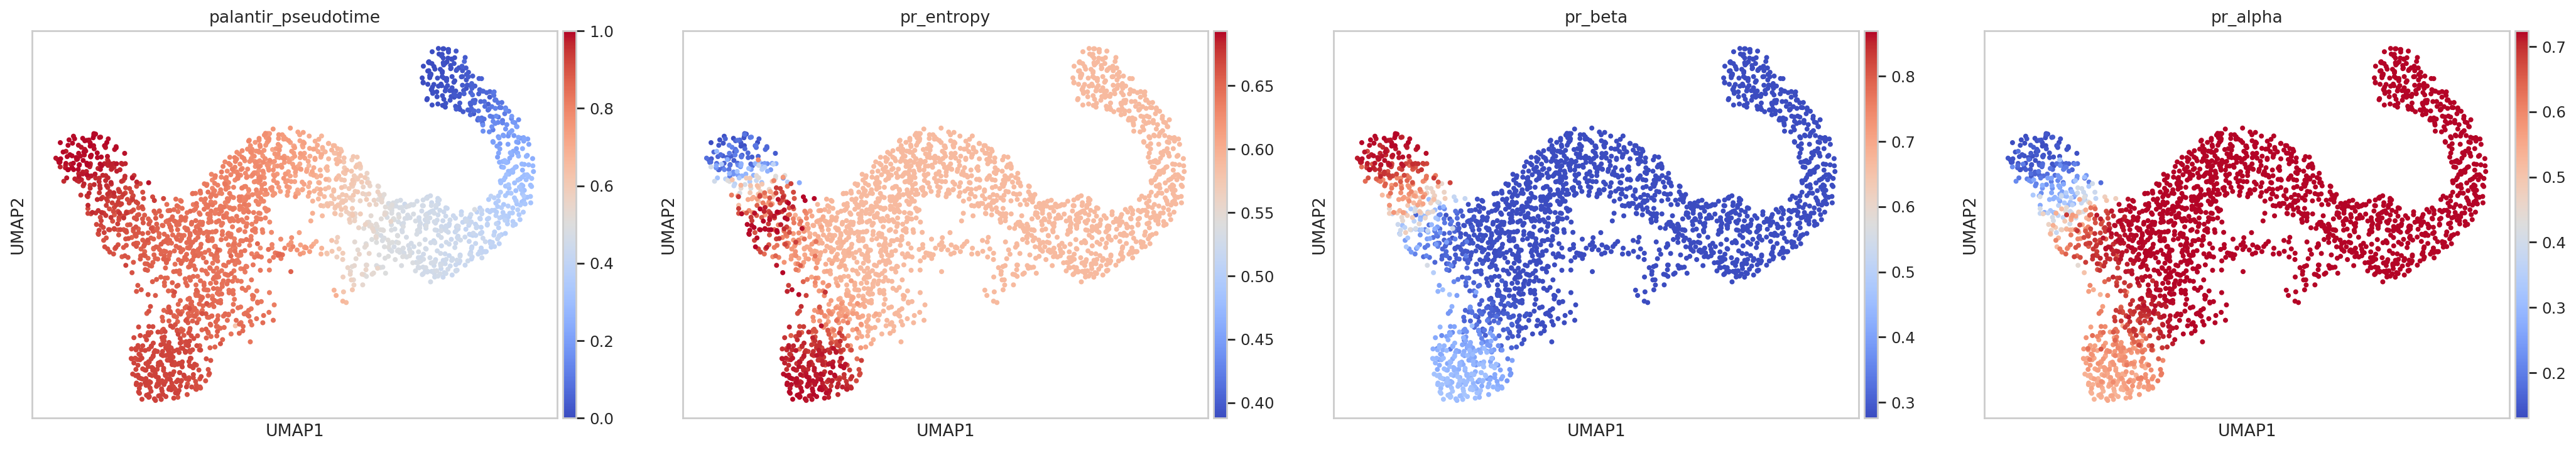

In [23]:
sc.pl.umap(adata, color=["palantir_pseudotime", "pr_entropy", "pr_beta", "pr_alpha"], cmap="coolwarm")

Что произошло? В целом, кажется, что картина после удаления дельта- и эпсилон-клеток стала несколько хуже. 

###2. С помощью результатов работы CellRank выделите гены, высоко скоррелированные с дифференцировкой только эпсилон-клеток, но не других типов клеток.

In [61]:
adata = adata_raw.copy()
scv.pp.moments(adata, n_pcs=None, n_neighbors=None)

Normalized count data: spliced, unspliced.
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [62]:
scv.tl.recover_dynamics(adata, n_jobs=-1) # ~5 minutes

recovering dynamics (using 2/2 cores)


  0%|          | 0/762 [00:00<?, ?gene/s]

    finished (0:04:52) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)


In [63]:
scv.tl.velocity(adata, mode="dynamical")
scv.tl.velocity_graph(adata)

computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/2 cores)


  0%|          | 0/2531 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [64]:
scv.tl.latent_time(adata)

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


In [65]:
scv.settings.set_figure_params("scvelo")

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


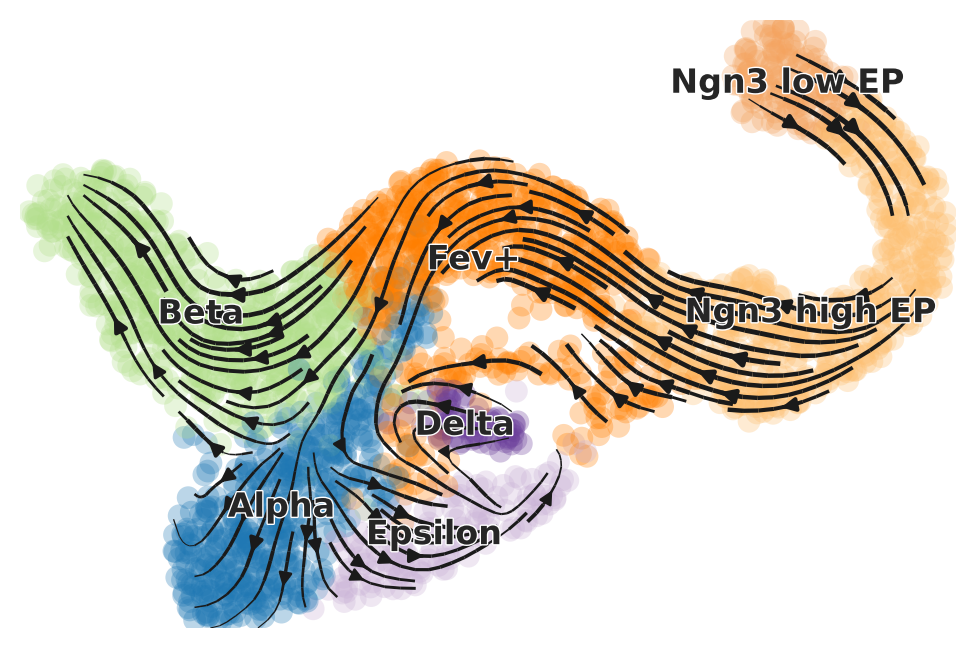

In [66]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4
)

/usr/local/lib/python3.8/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


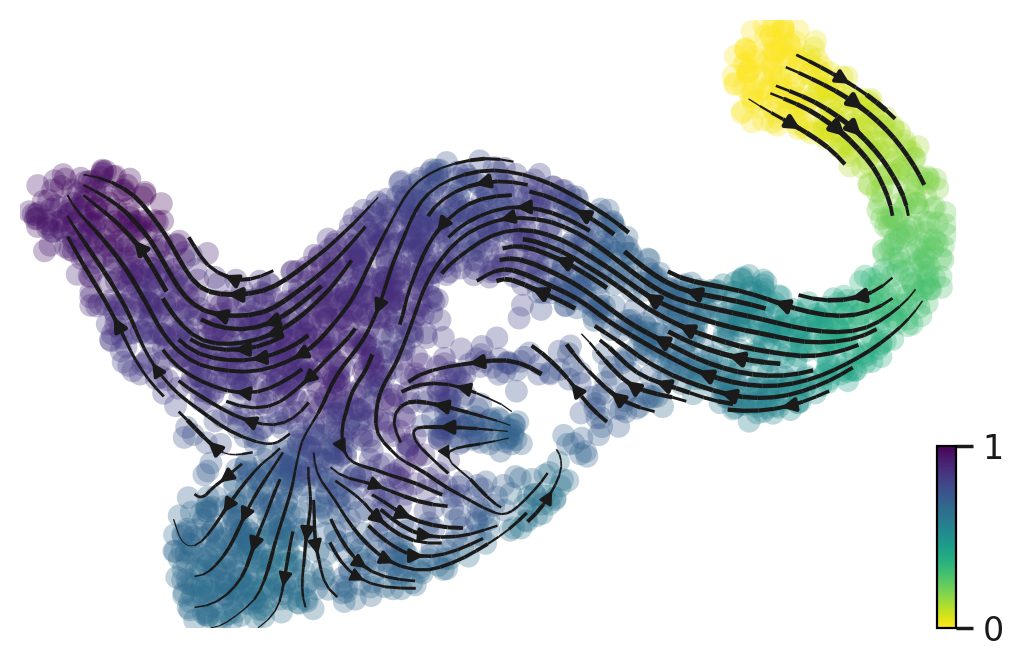

In [67]:
scv.pl.velocity_embedding_stream(
    adata, basis="umap", legend_fontsize=12, title="", smooth=0.4, min_mass=4, color="latent_time"
)

In [68]:
#запустим CellRank
from cellrank.tl.estimators import GPCCA
kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes
g = GPCCA(kernel)
g.compute_schur(n_components=20)
g.compute_macrostates(cluster_key="clusters", n_states=12)

Computing transition matrix based on logits using `'monte_carlo'` mode


<ipython-input-68-2084ec64fa9c>:3: DeprecationWarning: `cellrank.tl.transition_matrix` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  kernel = cr.tl.transition_matrix(adata, weight_connectivities=0.2, n_jobs=-1, mode='monte_carlo') # ~6 minutes


Estimating `softmax_scale` using `'deterministic'` mode


  0%|          | 0/2531 [00:00<?, ?cell/s]

Setting `softmax_scale=3.7939`


  0%|          | 0/2531 [00:00<?, ?sample/s]

    Finish (0:04:42)
Using a connectivity kernel with weight `0.2`
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[5, 8, 13, 15, 17, 20]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:30)
Computing `12` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:16)


/usr/local/lib/python3.8/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


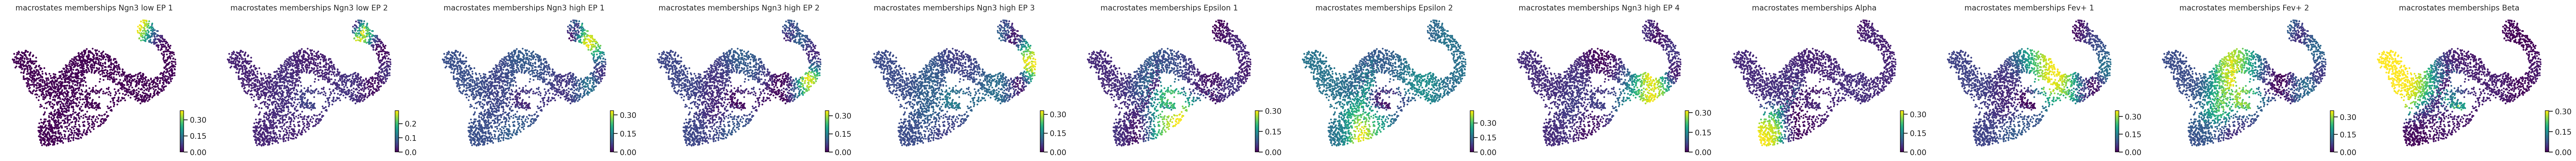

In [69]:
g.plot_macrostates(same_plot=False)

In [70]:
g.set_terminal_states_from_macrostates(names=["Epsilon_1", "Alpha", "Beta"])
g.compute_absorption_probabilities()

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing absorption probabilities


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['to_terminal_states']`
       `.absorption_probabilities`
    Finish (0:00:00)


In [71]:
cr.tl.lineage_drivers(adata)

Adding `adata.varm['terminal_lineage_drivers']`
       `.lineage_drivers`
    Finish (0:00:00)


<ipython-input-71-b827be8b05bf>:1: DeprecationWarning: `cellrank.tl.lineage_drivers` will be removed in version `2.0`. Please use the `cellrank.kernels` or `cellrank.estimators` interface instead.
  cr.tl.lineage_drivers(adata)


Epsilon_1_corr  Epsilon_1_pval  Epsilon_1_qval  Epsilon_1_ci_low  \
index                                                                       
Ghrl           0.703276    0.000000e+00    0.000000e+00          0.683029   
Anpep          0.523296   1.645305e-187   1.233978e-184          0.494415   
Mboat4         0.484884   4.511559e-156   1.127890e-153          0.454509   
Cdkn1a         0.465112   1.440941e-141   2.161412e-139          0.434015   
Gm11837        0.438648   9.506565e-124   1.296350e-121          0.406635   
...                 ...             ...             ...               ...   
Ins2          -0.473979   6.110136e-148   1.145651e-145         -0.503640   
Iapp          -0.477068   3.280786e-150   7.030256e-148         -0.506613   
Pcsk2         -0.501320   5.708784e-169   1.712635e-166         -0.529931   
Nnat          -0.507919   2.239956e-174   8.399837e-172         -0.536268   
Ppp1r1a       -0.515885   4.387180e-181   2.193590e-178         -0.543914   

         Epsilon_1_ci_high  Alpha_corr    Alpha_pval    Alpha_qval  \
index                                                                
Ghrl              0.722442   -0.130715  3.841500e-11  3.114730e-10   
Anpep             0.551024   -0.110076  2.744012e-08  1.653019e-07   
Mboat4            0.514133   -0.133701  1.352612e-11  1.133473e-10   
Cdkn1a            0.495102   -0.205161  1.266078e-25  2.713024e-24   
Gm11837           0.469584   -0.083338  2.670343e-05  1.164394e-04   
...                    ...         ...           ...           ...   
Ins2             -0.443201   -0.334449  1.750991e-68  1.250708e-66   
Iapp             -0.446404    0.103555  1.738000e-07  9.691452e-07   
Pcsk2            -0.471569    0.176657  2.799732e-19  3.817817e-18   
Nnat             -0.478425   -0.356405  2.241961e-78  2.149115e-76   
Ppp1r1a          -0.486706   -0.093485  2.427883e-06  1.186262e-05   

         Alpha_ci_low  Alpha_ci_high  Beta_corr      Beta_pval      Beta_qval  \
index                                                                           
Ghrl        -0.168817      -0.092223  -0.413103  3.942474e-108  2.956855e-106   
Anpep       -0.148401      -0.071420  -0.297423   1.198907e-53   3.458385e-52   
Mboat4      -0.171768      -0.095236  -0.250945   4.949597e-38   8.436813e-37   
Cdkn1a      -0.242187      -0.167539  -0.180923   3.649143e-20   3.065112e-19   
Gm11837     -0.121904      -0.044520  -0.256255   1.174593e-39   2.148646e-38   
...               ...            ...        ...            ...            ...   
Ins2        -0.368607      -0.299388   0.606877  2.062931e-274  1.031466e-271   
Iapp         0.064854       0.141944   0.268657   1.313700e-43   2.855868e-42   
Pcsk2        0.138649       0.214144   0.229581   6.846082e-32   9.687852e-31   
Nnat        -0.389952      -0.321914   0.648784   0.000000e+00   0.000000e+00   
Ppp1r1a     -0.131966      -0.054722   0.450234  2.460151e-131  2.170721e-129   

         Beta_ci_low  Beta_ci_high  
index                               
Ghrl       -0.444904     -0.380261  
Anpep      -0.332531     -0.261491  
Mboat4     -0.287100     -0.214077  
Cdkn1a     -0.218346     -0.142969  
Gm11837    -0.292299     -0.219485  
...              ...           ...  
Ins2        0.581668      0.630920  
Iapp        0.232125      0.304432  
Pcsk2       0.192340      0.266162  
Nnat        0.625637      0.670790  
Ppp1r1a     0.418616      0.480763  

[1500 rows x 15 columns]

In [72]:
set(adata.varm['terminal_lineage_drivers'])

{'Alpha_ci_high',
 'Alpha_ci_low',
 'Alpha_corr',
 'Alpha_pval',
 'Alpha_qval',
 'Beta_ci_high',
 'Beta_ci_low',
 'Beta_corr',
 'Beta_pval',
 'Beta_qval',
 'Epsilon_1_ci_high',
 'Epsilon_1_ci_low',
 'Epsilon_1_corr',
 'Epsilon_1_pval',
 'Epsilon_1_qval'}

In [73]:
#возьмем гены высоко скоррелированные с дифференцировкой только эпсилон-клеток, но не других типов клеток
adata = adata[:, list((adata.varm['terminal_lineage_drivers']['Epsilon_1_corr'] > 0.7) & (adata.varm['terminal_lineage_drivers']['Alpha_corr'] < 0.05) & (adata.varm['terminal_lineage_drivers']['Beta_corr'] < 0.05))]
adata

View of AnnData object with n_obs × n_vars = 2531 × 1
    obs: 'day', 'proliferation', 'G2M_score', 'S_score', 'phase', 'clusters_coarse', 'clusters', 'clusters_fine', 'louvain_Alpha', 'louvain_Beta', 'palantir_pseudotime', 'n_counts', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time', 'terminal_states', 'terminal_states_probs'
    var: 'highly_variable_genes', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'clusters_colors', 'clusters_fine_colors', 'louvain_Alpha_colors', 'louvain_Beta_colors', 'neighbors', 'pca', 'log1p', 'hvg', 'recover_dynamics', 'velocity_params', 'velocity_graph', 'velocity_graph_neg', 'T_fwd_params', 'schur_matrix_fwd', 'e

/usr/local/lib/python3.8/dist-packages/scvelo/plotting/utils.py:869: MatplotlibDeprecationWarning: The draw_all function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use fig.draw_without_rendering() instead.
  cb.draw_all()


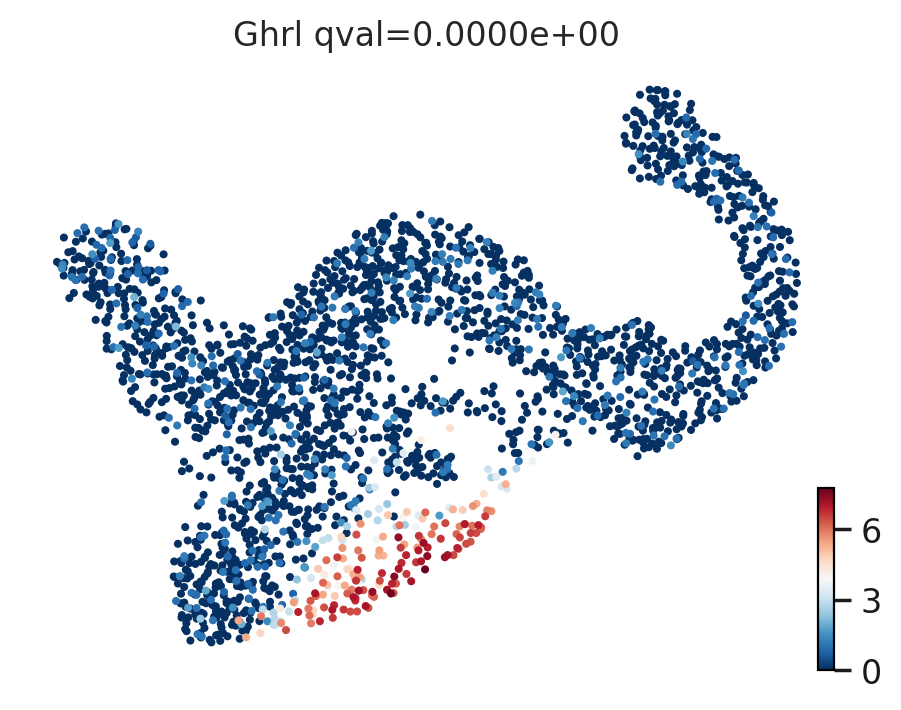

In [74]:
cr.pl.lineage_drivers(adata, lineage="Epsilon_1")

###Получите индекс клетки, в которой общая экспрессия этих генов выше, чем в остальных. Отрисуйте эту клетку на UMAP и t-SNE аналогично тому, как мы делали это на семинаре для терминальных клеток Palantir.

In [75]:
my_cell = adata[adata.X.sum(axis=1).argmax(), :].obs.index[0]
adata = adata_raw.copy()
cluster_dict = {"Epsilon": adata.obs["clusters"] == "Epsilon"}
cluster_cells = {"Epsilon": adata.obs.index==my_cell}

In [76]:
sce.tl.palantir(adata, n_components=5, knn=30)
sc.tl.tsne(adata, n_pcs=2, use_rep='X_palantir_multiscale', perplexity=90)

Determing nearest neighbor graph...


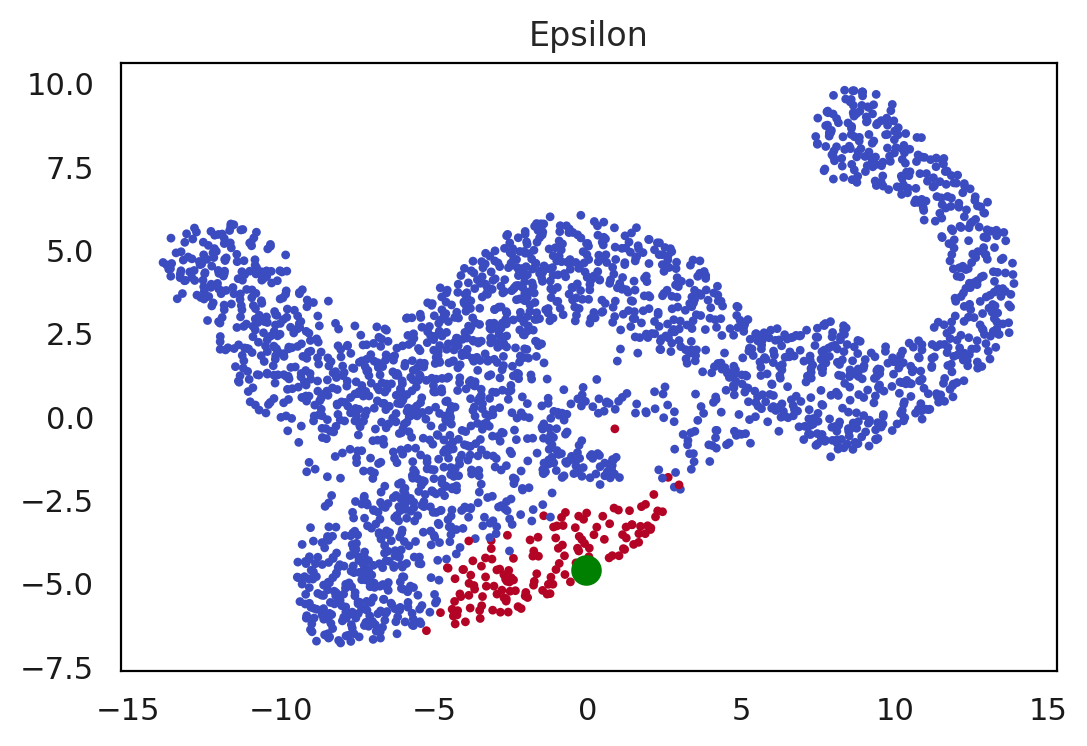

In [79]:
fig,axs = plt.subplots(1,1)
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_umap"][:,0], adata.obsm["X_umap"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_umap"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_umap"][:,1][cluster_cells[cur_cluster]], c="green", s=100)
  ax.set_title(cur_cluster)

Видно, что UMAP выдал положение клетки в нужном месте.

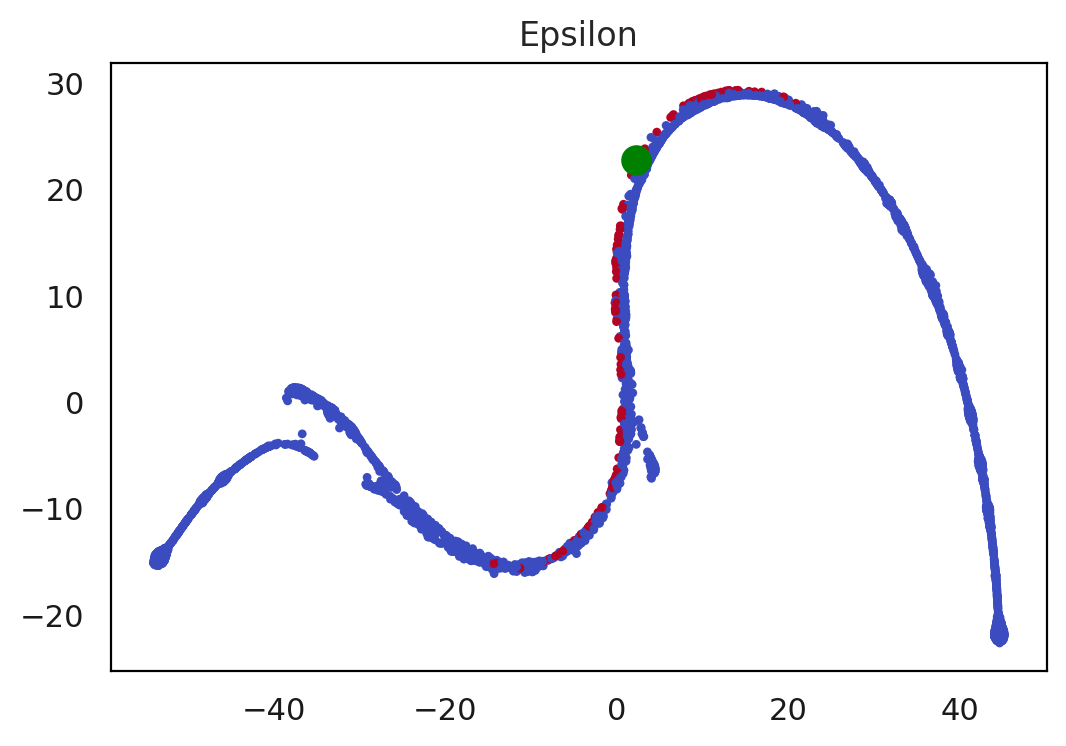

In [80]:
fig,axs = plt.subplots(1,1)
for i, ax in enumerate(fig.axes):
  cur_cluster = list(cluster_dict.keys())[i]
  sns.scatterplot(adata.obsm["X_tsne"][:,0], adata.obsm["X_tsne"][:,1], c=cluster_dict[cur_cluster], ax=ax, cmap="coolwarm", linewidth=0, s=10)
  ax.scatter(adata.obsm["X_tsne"][:,0][cluster_cells[cur_cluster]],
             adata.obsm["X_tsne"][:,1][cluster_cells[cur_cluster]], c="green", s=100)
  ax.set_title(cur_cluster)

По t-sne тоже видно, что клетка находтся среди красных точек.